# Evaluating embedding distances
> Exploring distributions of distances and correlating them to other things we care about

# OTU-level distances

In [2]:
import anndata

# Load the mlrepo
mlrepo = anndata.read_h5ad("../data/mlrepo4.h5ad")
mlrepo

AnnData object with n_obs × n_vars = 10037 × 27105
    obs: 'ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score', 'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum', 'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum', 'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age', 'yatsunenko_malawi-venezuela', 'yatsunenko_sex', 'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex', 'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired', 'cho_control-ct-cecal', 'cho_control-ct-fecal', 'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal', 'turnbaugh_obese-lean-all'
    var: 'k', 'p', 'c', 'o', 'f', 'g', 's', 'fasta'
    obsm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    varm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    obsp: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', '

In [5]:
# Correlations between all distances in varp
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Get all distance matrices from varp
distance_matrices = list(mlrepo.varp.keys())
print(f"Found {len(distance_matrices)} distance matrices in varp: {distance_matrices}")

# Create a dataframe to store correlations between all pairs of distance matrices
correlations = pd.DataFrame(index=distance_matrices, columns=distance_matrices)

# For each pair of distance matrices, compute the correlation
my_tqdm = tqdm(total=int(len(distance_matrices) * (len(distance_matrices) - 1) / 2))
for i, dist1 in enumerate(distance_matrices):
    # for j, dist2 in enumerate(distance_matrices):
    for j in range(i):
        dist2 = distance_matrices[j]
        # Get the distance matrices
        dm1 = mlrepo.varp[dist1]
        dm2 = mlrepo.varp[dist2]

        # Convert to 1D arrays (taking only the upper triangle to avoid redundancy)
        mask = np.triu_indices_from(dm1, k=1)
        dm1_flat = dm1[mask]
        dm2_flat = dm2[mask]

        # Compute correlation
        corr = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
        correlations.loc[dist1, dist2] = corr
        correlations.loc[dist2, dist1] = corr
        my_tqdm.update(1)

Found 16 distance matrices in varp: ['E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s', 'gg_tree_distances']


  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
# Save results

correlations.to_csv("../results/varp_distance_correlations.csv")

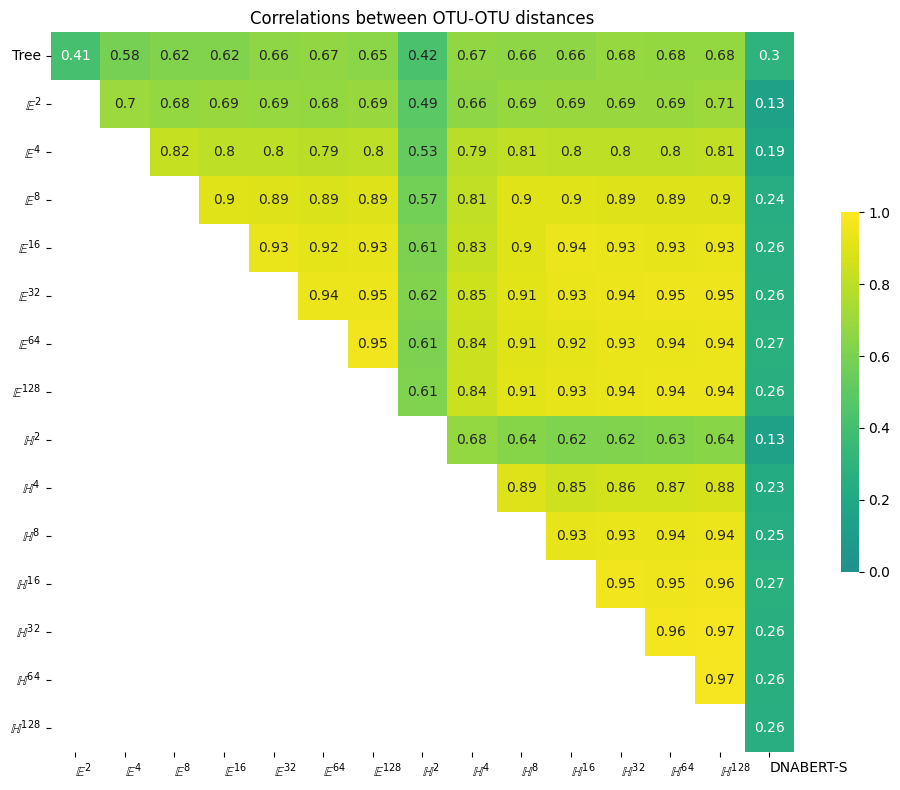

Summary of correlations:
Mean correlation: nan
Min correlation: nan
Max correlation: nan


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlations = pd.read_csv("../results/varp_distance_correlations.csv", index_col=0)
# Fix indices
order = [
    ("gg_tree_distances", "Tree"),
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
]
correlations = correlations.loc[[x[0] for x in order], [x[0] for x in order]]

# Zero out lower triangle; drop last empty row and first column
correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(bool))
correlations = correlations.iloc[:-1, 1:]
correlations = correlations.rename(index=dict(order), columns=dict(order))

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="viridis", vmin=0, vmax=1, center=0, cbar_kws={"shrink": 0.5})
plt.xticks(rotation=0, ha="left")
plt.yticks(rotation=0, ha="right")
plt.title("Correlations between OTU-OTU distances")
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of correlations:")
print(f"Mean correlation: {correlations.values.mean():.3f}")
print(f"Min correlation: {correlations.values.min():.3f}")
print(f"Max correlation: {correlations.values.max():.3f}")

# Save figure
plt.savefig("../figures/varp_distance_correlations.pdf", bbox_inches="tight", dpi=300)

# Sample-level distances

In [2]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo4.h5ad")

In [3]:
%%bash

# Compute unifrac with "ssu", which can be found at https://github.com/biocore/unifrac-binaries

export UNIFRAC_GPU_INFO=Y

unifrac_path="/home/phil/miniconda3/envs/unifrac/bin/ssu"
biom_path="../data/mlrepo.biom"
tree_path="../data/greengenes/trees/99_otus.tree"
out_path_unweighted="../results/unweighted_unifrac.tsv"
out_path_weighted="../results/weighted_unifrac.tsv"

echo "starting..."
if [ ! -f $out_path_unweighted.gz ]; then
    $unifrac_path -i $biom_path -o $out_path_unweighted -m unweighted -t $tree_path
    echo "done - unweighted"
    gzip -f $out_path_unweighted
    echo "done - unweighted; gzipped"
fi
if [ ! -f $out_path_weighted.gz ]; then
    $unifrac_path -i $biom_path -o $out_path_weighted -m weighted_normalized -t $tree_path
    echo "done - weighted"
    gzip -f $out_path_weighted
    echo "done - weighted; gzipped"
fi

starting...


gzip: ../results/unweighted_unifrac.tsv.gz already exists;	not overwritten
gzip: ../results/weighted_unifrac.tsv: No such file or directory


CalledProcessError: Command 'b'# Compute unifrac with "ssu", which can be found at https://github.com/biocore/unifrac-binaries\n\nexport UNIFRAC_GPU_INFO=Y\n\nunifrac_path="/home/phil/miniconda3/envs/unifrac/bin/ssu"\nbiom_path="../data/mlrepo.biom"\ntree_path="../data/greengenes/trees/99_otus.tree"\nout_path_unweighted="../results/unweighted_unifrac.tsv"\nout_path_weighted="../results/weighted_unifrac.tsv"\n\necho "starting..."\nif [ ! -f $out_path_unweighted.gz ]; then\n    $unifrac_path -i $biom_path -o $out_path_unweighted -m unweighted -t $tree_path\n    echo "done - unweighted"\nfi\nif [ ! -f $out_path_weighted.gz ]; then\n    $unifrac_path -i $biom_path -o $out_path_weighted -m weighted_normalized -t $tree_path\n    echo "done - weighted"\nfi\n\ngzip $out_path_unweighted\ngzip $out_path_weighted\n'' returned non-zero exit status 1.

In [3]:
# Add distance matrices to mlrepo
import pandas as pd

for metric in ["unweighted_unifrac", "weighted_unifrac"]:
    dists = pd.read_table(f"../results/{metric}.tsv.gz", sep="\t", index_col=0)
    dists = dists.loc[mlrepo.obs.index, mlrepo.obs.index]
    mlrepo.obsp[metric] = dists.values

In [4]:
mlrepo.write_h5ad("../data/mlrepo5.h5ad")

In [ ]:
import anndata
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

for metric in [
    "braycurtis", 
    # "jaccard", 
    "manhattan", 
    # "jensenshannon"
]:
    print(f"Computing {metric} distance matrix")
    dists = pairwise_distances(mlrepo.X, metric=metric, n_jobs=-1)
    mlrepo.obsp[metric] = dists
    del dists

for metric in ["euclidean", "cosine"]:
    print(f"Computing {metric} distance matrix")
    dists = pairwise_distances(mlrepo.X, metric=metric, n_jobs=1)  # They're already parallelized on the backend
    mlrepo.obsp[metric] = dists
    del dists

Computing euclidean distance matrix
Computing cosine distance matrix


In [3]:
# Save results
mlrepo.write_h5ad("../data/mlrepo5.h5ad")
mlrepo

AnnData object with n_obs × n_vars = 10037 × 27105
    obs: 'ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score', 'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum', 'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum', 'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age', 'yatsunenko_malawi-venezuela', 'yatsunenko_sex', 'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex', 'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired', 'cho_control-ct-cecal', 'cho_control-ct-fecal', 'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal', 'turnbaugh_obese-lean-all'
    var: 'k', 'p', 'c', 'o', 'f', 'g', 's', 'fasta'
    obsm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    varm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    obsp: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', '

# Correlations - sample-level distances

In [1]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [5]:
# Correlations
import pandas as pd
import numpy as np
import anndata
from tqdm.notebook import tqdm

# Get all distance matrices from varp
distance_matrices = list(mlrepo.obsp.keys())
print(f"Found {len(distance_matrices)} distance matrices in obsp: {distance_matrices}")

# Create a dataframe to store correlations between all pairs of distance matrices
correlations = pd.DataFrame(index=distance_matrices, columns=distance_matrices)

# For each pair of distance matrices, compute the correlation
my_tqdm = tqdm(total=int(len(distance_matrices) * (len(distance_matrices) - 1) / 2))
for i, dist1 in enumerate(distance_matrices):
    # for j, dist2 in enumerate(distance_matrices):
    for j in range(i):
        dist2 = distance_matrices[j]
        # Get the distance matrices
        dm1 = mlrepo.obsp[dist1]
        dm2 = mlrepo.obsp[dist2]

        # Convert to 1D arrays (taking only the upper triangle to avoid redundancy)
        mask = np.triu_indices_from(dm1, k=1)
        dm1_flat = dm1[mask]
        dm2_flat = dm2[mask]

        # Compute correlation
        corr = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
        correlations.loc[dist1, dist2] = corr
        correlations.loc[dist2, dist1] = corr
        my_tqdm.update(1)

Found 21 distance matrices in obsp: ['E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s', 'unweighted_unifrac', 'weighted_unifrac', 'braycurtis', 'manhattan', 'euclidean', 'cosine']


  0%|          | 0/210 [00:00<?, ?it/s]

In [7]:
# Save results

correlations.to_csv("../results/obsp_distance_correlations.csv")

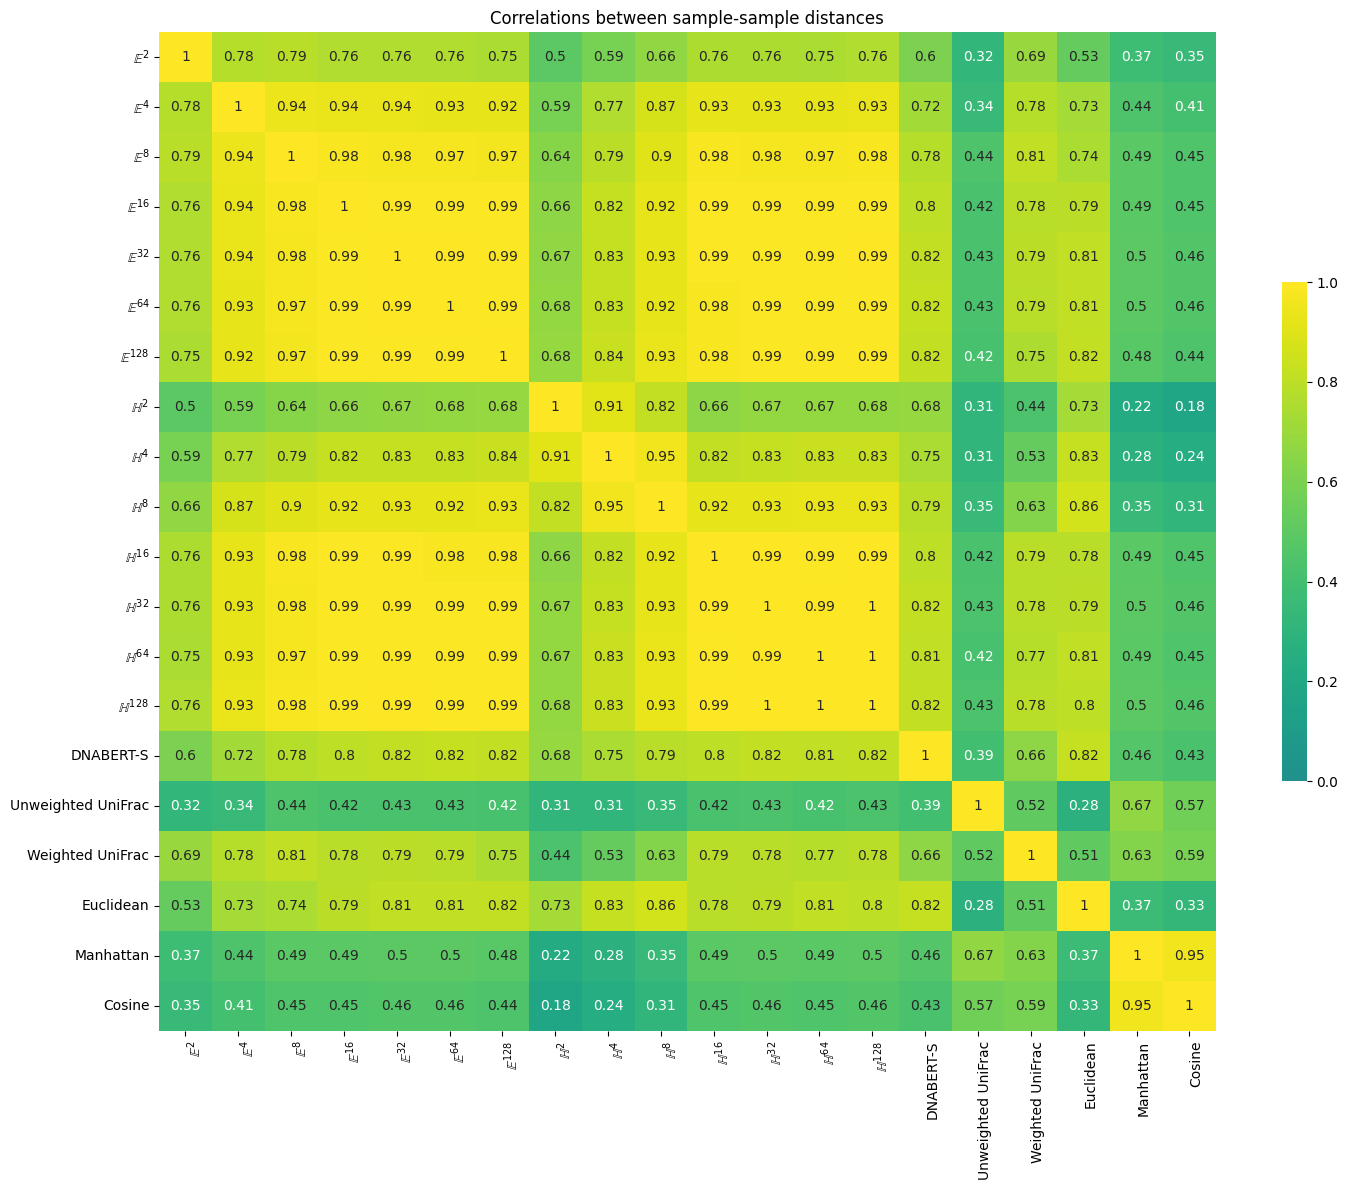

Summary of correlations:
Mean correlation: 0.735
Min correlation: 0.183
Max correlation: 1.000


<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlations = pd.read_csv("../results/obsp_distance_correlations.csv", index_col=0)
# Fix indices
order = [
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
    ("unweighted_unifrac", "Unweighted UniFrac"),
    ("weighted_unifrac", "Weighted UniFrac"),
    ("euclidean", "Euclidean"),
    ("manhattan", "Manhattan"),
    ("cosine", "Cosine"),
    # ("braycurtis", "Bray-Curtis"),
]
correlations = correlations.loc[[x[0] for x in order], [x[0] for x in order]]

# Zero out lower triangle; drop last empty row and first column
# correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(bool))
# correlations = correlations.iloc[:-1, 1:]
# Set diagonal to 1.
# Set diagonal to 1 by filling the diagonal of the numpy array
np.fill_diagonal(correlations.values, 1.0)

correlations = correlations.rename(index=dict(order), columns=dict(order))

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, cmap="viridis", vmin=0, vmax=1, center=0, cbar_kws={"shrink": 0.5})
plt.xticks(rotation=90, ha="left")
plt.yticks(rotation=0, ha="right")
plt.title("Correlations between sample-sample distances")
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of correlations:")
print(f"Mean correlation: {correlations.values.mean():.3f}")
print(f"Min correlation: {correlations.values.min():.3f}")
print(f"Max correlation: {correlations.values.max():.3f}")

# Save figure
plt.savefig("../figures/obsp_distance_correlations.pdf", bbox_inches="tight", dpi=300)